In [21]:
import random, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils import preprocess, all_paths_exist

In [22]:
raw_folders = [
    'good 1',
    'track 1 normal',
    'track 1 normal 2',
    'track 1 normal 3',
    'track 1 reverse',
    'track 1 reverse 2',
    'track 1 reverse 3',
    'track 1 edges normal 1',
]

In [23]:
def extract_file_name(path):
    return path.split('\\')[-1]


def read_raw_driving_csv(folder: str):
    csv_path = '.\\data\\raw\\{0}\\driving_log.csv'.format(folder)

    with open(csv_path, 'r') as f:
        csv = pd.read_csv(
            csv_path,
            header=None,
            names=['center', 'left', 'right', 'steering_angle'],
            usecols=[0, 1, 2, 3],
            converters={
                'center': lambda x: extract_file_name(x),
                'left': lambda x: extract_file_name(x),
                'right': lambda x: extract_file_name(x)
            }
        )

        return csv

In [24]:
def remove_non_triple_images(raw_folders):
    for folder in raw_folders:
        remove_indexes = []
        print('-- Checking {0}'.format(folder))

        df = read_raw_driving_csv(folder)
        print('DF Before: ', len(df))

        for index, row in df.iterrows():
            center = '.\\data\\raw\\{0}\\IMG\\{1}'.format(folder, row['center'])
            left = '.\\data\\raw\\{0}\\IMG\\{1}'.format(folder, row['left'])
            right = '.\\data\\raw\\{0}\\IMG\\{1}'.format(folder, row['right'])

            # if an image does not exist, remove all images from the same row
            if not all_paths_exist([center, left, right]):
                for path in [center, left, right]:
                    if os.path.exists(path):
                        os.remove(path)

                remove_indexes.append(index)

        df.drop(index=df.index[remove_indexes], inplace=True)
        print('DF After : ', len(df))

        csv_path = '.\\data\\raw\\{0}\\driving_log.csv'.format(folder)
        df.to_csv(csv_path, index=False, header=False)

In [25]:
remove_non_triple_images(raw_folders)

-- Checking good 1
DF Before:  10405
DF After :  10405
-- Checking track 1 normal
DF Before:  2194
DF After :  2194
-- Checking track 1 normal 2
DF Before:  1996
DF After :  1996
-- Checking track 1 normal 3
DF Before:  9305
DF After :  9305
-- Checking track 1 reverse
DF Before:  2934
DF After :  2934
-- Checking track 1 reverse 2
DF Before:  6948
DF After :  6948
-- Checking track 1 reverse 3
DF Before:  5462
DF After :  5462
-- Checking track 1 edges normal 1
DF Before:  1756
DF After :  1756


# Load and Visualize Dataset

In [26]:
full_set = pd.DataFrame()

for folder in raw_folders:
    df = read_raw_driving_csv(folder)
    df['folder'] = folder
    full_set = pd.concat([full_set, df], ignore_index=True)

In [27]:
full_set.dtypes

center             object
left               object
right              object
steering_angle    float64
folder             object
dtype: object

In [28]:
full_set.head()

,center,left,right,steering_angle,folder
0,center_2019_04_02_19_25_35_023.jpg,left_2019_04_02_19_25_35_023.jpg,right_2019_04_02_19_25_35_023.jpg,0.00,good 1
1,center_2019_04_02_19_25_35_092.jpg,left_2019_04_02_19_25_35_092.jpg,right_2019_04_02_19_25_35_092.jpg,-0.15,good 1
2,center_2019_04_02_19_25_35_164.jpg,left_2019_04_02_19_25_35_164.jpg,right_2019_04_02_19_25_35_164.jpg,0.00,good 1
3,center_2019_04_02_19_25_35_232.jpg,left_2019_04_02_19_25_35_232.jpg,right_2019_04_02_19_25_35_232.jpg,0.00,good 1
4,center_2019_04_02_19_25_35_303.jpg,left_2019_04_02_19_25_35_303.jpg,right_2019_04_02_19_25_35_303.jpg,0.00,good 1


In [29]:
full_set.iloc[1]

center            center_2019_04_02_19_25_35_092.jpg
left                left_2019_04_02_19_25_35_092.jpg
right              right_2019_04_02_19_25_35_092.jpg
steering_angle                                 -0.15
folder                                        good 1
Name: 1, dtype: object

In [30]:
full_set.iloc[1]['folder']

'good 1'

In [31]:
full_set['steering_angle'][1]

-0.15

# Balance the Dataset

In [32]:
num_bins = 21
samples_per_bin = 2350

In [33]:
def show_steering_angles(full_set, hist, bins, samples_per_bin):
    center = (bins[:-1] + bins[1:]) * 0.5
    plt.bar(center, hist, width=0.05)
    plt.plot(
        (np.min(full_set['steering_angle']), np.max(full_set['steering_angle'])),
        (samples_per_bin, samples_per_bin)
    )

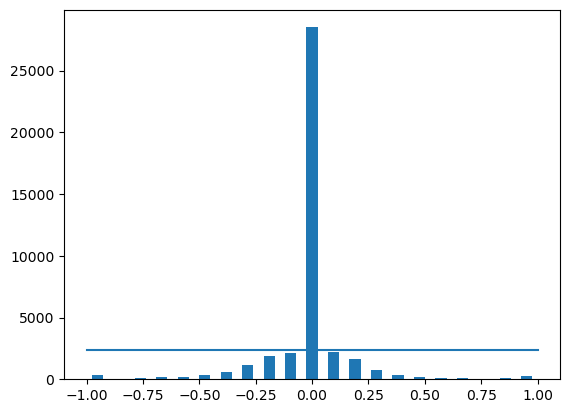

In [34]:
hist, bins = np.histogram(full_set['steering_angle'], num_bins)
show_steering_angles(full_set, hist, bins, samples_per_bin)

In [35]:
print('total data:', len(full_set))
remove_list = []

for j in range(num_bins):
  list_ = []
  for i in range(len(full_set['steering_angle'])):
    if bins[j] <= full_set['steering_angle'][i] <= bins[j + 1]:
      list_.append(i)

  random.shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)

print('removed:', len(remove_list))
full_set.drop(full_set.index[remove_list], inplace=True)
print('remaining:', len(full_set))

total data: 41000
removed: 26154
remaining: 14846


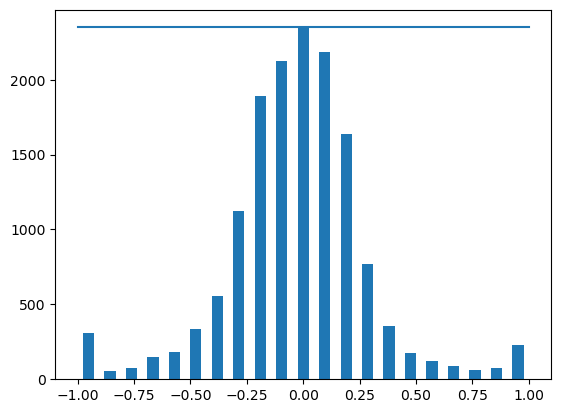

In [36]:
hist, bins = np.histogram(full_set['steering_angle'], num_bins)
show_steering_angles(full_set, hist, bins, samples_per_bin)

# Split the CSV

In [37]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(full_set, train_size=0.9, shuffle=True)

In [38]:
len(full_set), len(X_train), len(X_test)

(14846, 13361, 1485)

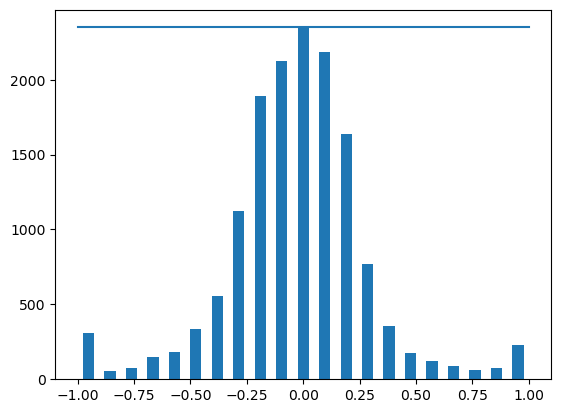

In [39]:
show_steering_angles(X_train, hist, bins, samples_per_bin)

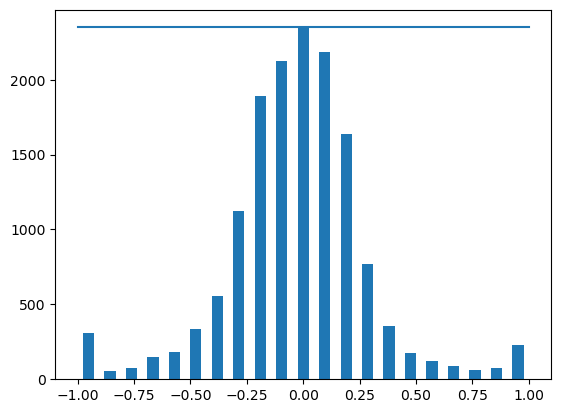

In [40]:
show_steering_angles(X_test, hist, bins, samples_per_bin)

In [41]:
X_train.head()

,center,left,right,steering_angle,folder
15330,center_2023_05_10_12_05_00_633.jpg,left_2023_05_10_12_05_00_633.jpg,right_2023_05_10_12_05_00_633.jpg,-0.254207,track 1 normal 3
685,center_2019_04_02_19_26_24_255.jpg,left_2019_04_02_19_26_24_255.jpg,right_2019_04_02_19_26_24_255.jpg,0.000000,good 1
34174,center_2023_05_10_18_39_19_905.jpg,left_2023_05_10_18_39_19_905.jpg,right_2023_05_10_18_39_19_905.jpg,0.281031,track 1 reverse 3
37856,center_2023_05_10_18_46_22_546.jpg,left_2023_05_10_18_46_22_546.jpg,right_2023_05_10_18_46_22_546.jpg,0.209534,track 1 reverse 3
24765,center_2023_04_28_21_08_18_431.jpg,left_2023_04_28_21_08_18_431.jpg,right_2023_04_28_21_08_18_431.jpg,0.000000,track 1 reverse


# Preprocess Images

In [49]:
import shutil

def clear_folder(folder):
    for files in os.listdir(folder):
        path = os.path.join(folder, files)
        try:
            shutil.rmtree(path)
        except OSError:
            os.remove(path)


In [55]:
from torchvision.io import read_image
from PIL import Image

PREPROCESSED_FOLDER = '.\\data\\preprocessed\\'

def preprocess_and_store_images(df, stage):
    if not os.path.isdir(PREPROCESSED_FOLDER):
        os.mkdir(PREPROCESSED_FOLDER)

    if not os.path.isdir(PREPROCESSED_FOLDER + stage):
        os.mkdir(PREPROCESSED_FOLDER + stage)
    else:
        clear_folder(PREPROCESSED_FOLDER + stage)

    for index, row in df.iterrows():
        folder = row['folder']

        for image_name in ['center']: #  ['center', 'left', 'right']:
            image_name = row[image_name]
            raw_path = '.\\data\\raw\\' + folder + '\\IMG\\' + image_name

            if not os.path.exists(raw_path):
                continue

            image = read_image(raw_path)
            image = preprocess(image)

            path = '{}\\{}\\{}'.format(PREPROCESSED_FOLDER, stage, image_name)
            Image.fromarray(image.numpy().transpose(1, 2, 0)).save(path)

In [56]:
preprocess_and_store_images(X_train, 'train')
preprocess_and_store_images(X_test, 'test')

In [57]:
# compare left, center, right images count
len(X_train), len(X_train) * 3, len(os.listdir('.\\data\\preprocessed\\train'))

(13361, 40083, 13361)

In [58]:
len(X_test), len(X_test) * 3, len(os.listdir('.\\data\\preprocessed\\test'))

(1485, 4455, 1485)

# Save CSV

In [59]:
X_train.to_csv(
    '.\\data\\preprocessed\\driving_train_log.csv',
    index=False,
    columns=['center', 'left', 'right', 'steering_angle']
)

X_test.to_csv(
    '.\\data\\preprocessed\\driving_test_log.csv',
    index=False,
    columns=['center', 'left', 'right', 'steering_angle']
)